In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import numpy as np
import math
import scipy
from numpy.linalg import lstsq
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import datetime as dt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
appVolDat = pd.read_csv('../data/filingVolumes.csv')
appVolDat = appVolDat.iloc[1272:1391] #outlier
appVolDat = appVolDat.reset_index(drop=True)
std = np.std(appVolDat.volume)
mu = np.mean(appVolDat.volume)
appVolDat['vol'] = (appVolDat.volume - mu) / std

trend = pd.read_csv('../data/trend_costOfPatent.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend1'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_utilityVDesign.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend2'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_uspto.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend3'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_patentApplicationProcess.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend4'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_patentApplicationSearch.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend5'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_efs-web.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend6'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_patentsView.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend7'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_fileForPatent.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend8'] = (trend - np.mean(trend)) / np.std(trend)

trend = pd.read_csv('../data/trend_patentFilingFees.csv').trends.iloc[24:144].reset_index(drop=True)/100
appVolDat['trend9'] = (trend - np.mean(trend)) / np.std(trend)

trendVolShiftDictionary = {'trend1':'Cost Of Patent', 'trend2': 'Utility vs. Design', 'trend3':'USPTO', \
'trend4': 'Patent Application Process', 'trend5': 'Patent Application Search', 'trend6':'EFS-Web', 'trend7':'Patentsview', \
'trend8': 'File For Patent', 'trend9': 'Patent Filing Fees', 'volShift1':'volShift1', 'volShift2':'volShift2', \
'volShift3':'volShift3', 'volShift4':'volShift4', 'volShift5':'volShift5', 'volShift6':'volShift6', 'volShift7':'volShift7', \
'volShift8':'volShift8', 'volShift9':'volShift9', 'volShift10':'volShift10', 'volShift11':'volShift11', 'volShift12':'volShift12'}
for i in range(1,13):
    appVolDat['volShift'+str(i)] = appVolDat.vol.shift(i)
appVolDat = appVolDat.iloc[12:]

In [3]:
X_train = appVolDat.iloc[:84]
X_test = appVolDat.iloc[84:107] #last data point is outlier
#X_train, X_test = train_test_split(appVolDat, test_size=0.25, random_state=0)
print("Num rows in X_train:", len(X_train))
print("Num rows in X_test:", len(X_test))
X_train

Num rows in X_train: 84
Num rows in X_test: 23


,month,volume,vol,trend1,trend2,trend3,trend4,trend5,trend6,trend7,...,volShift3,volShift4,volShift5,volShift6,volShift7,volShift8,volShift9,volShift10,volShift11,volShift12
12,1/1/2007,37114,-0.594790,-1.763116,-0.795465,0.889771,1.410426,1.018305,1.650659,-1.278034,...,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859,-1.247319,-1.215285
13,2/1/2007,35188,-0.916133,0.590458,-0.795465,0.653025,0.170078,-1.834276,-0.859115,0.602772,...,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859,-1.247319
14,3/1/2007,44173,0.582964,-0.772137,-0.795465,0.061159,-0.055440,0.819288,3.919109,2.091744,...,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859
15,4/1/2007,37711,-0.495184,-0.772137,-0.795465,1.126518,-0.055440,-1.170885,3.967374,0.367672,...,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520
16,5/1/2007,40160,-0.086582,-0.957946,-0.795465,0.771398,-1.295788,-1.966954,-0.859115,1.778276,...,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303
17,6/1/2007,41242,0.093943,-0.276648,-0.795465,2.665368,-0.055440,0.089558,-0.859115,2.013377,...,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238
18,7/1/2007,36923,-0.626658,-1.391499,-0.795465,0.889771,-1.295788,-0.706511,-0.859115,-1.278034,...,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747
19,8/1/2007,40940,0.043556,-1.948925,-0.795465,1.836756,0.959390,-1.369902,1.216275,0.210938,...,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998
20,9/1/2007,38331,-0.391741,-1.886988,-0.795465,1.008145,2.086979,-0.175799,1.216275,-1.278034,...,0.093943,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070
21,10/1/2007,48968,1.382983,-1.639244,-0.795465,1.718383,0.733873,-0.441155,-0.859115,-1.278034,...,-0.626658,0.093943,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056


In [4]:
X_test

,month,volume,vol,trend1,trend2,trend3,trend4,trend5,trend6,trend7,...,volShift3,volShift4,volShift5,volShift6,volShift7,volShift8,volShift9,volShift10,volShift11,volShift12
96,1/1/2014,40503,-0.029355,-0.400521,0.652892,-0.175587,-0.280958,1.018305,0.540567,-0.102530,...,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546,0.145498,-0.079575
97,2/1/2014,41112,0.072253,1.581437,-0.795465,-0.175587,-0.731993,0.686610,1.216275,-0.572732,...,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546,0.145498
98,3/1/2014,62356,3.616696,0.590458,1.105504,-0.057214,-1.070270,0.951966,-0.376466,-0.964566,...,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546
99,4/1/2014,44000,0.554100,1.024011,0.200281,-0.057214,0.282837,-0.242138,-0.859115,-0.259264,...,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043
100,5/1/2014,44872,0.699588,1.209820,2.282295,-0.530706,-1.070270,0.620271,-0.328201,-0.572732,...,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274
101,6/1/2014,47230,1.093008,0.900139,-0.795465,0.771398,0.282837,0.222236,0.299242,0.132571,...,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540
102,7/1/2014,43508,0.472013,0.094969,0.336064,-0.057214,-0.055440,0.155897,-0.279936,-0.337631,...,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068
103,8/1/2014,41927,0.208232,-0.772137,2.599123,-0.293960,0.733873,0.155897,-0.328201,-0.886199,...,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373
104,9/1/2014,47693,1.170256,0.466586,-0.252331,-0.057214,-0.731993,-0.772850,1.264540,0.210938,...,1.093008,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000
105,10/1/2014,45378,0.784012,1.147884,0.245542,-0.057214,-0.506475,-0.374816,0.154448,0.289305,...,0.472013,1.093008,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772


In [5]:
variables = ['volShift1', 'volShift2', 'volShift3', 'volShift4', 'volShift5', 'volShift6', 'volShift7', 'volShift8', 'volShift9', 'volShift10', 'volShift11', 'volShift12', 
                 'trend1','trend2','trend3','trend4','trend5','trend6','trend7','trend8','trend9',]
def func(X,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z):
    parameters = [a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z]
    sumFunc = 0.0
    for var in range(len(variables)):
        sumFunc += parameters[var]*X[variables[var]]
    return sumFunc

In [6]:
fitParams, fitCovariances = curve_fit(func, X_train, np.array(X_train['vol']))
print(fitParams)

[-0.09893265  0.0721132   0.10281454  0.17714237  0.17040868  0.1095406
  0.11416813 -0.07777901  0.08863351 -0.31822784 -0.24101754  0.63261328
  0.12249     0.02644896  0.21827038 -0.07727595  0.15443251  0.07632416
 -0.09349702  0.0066614   0.06909871  1.          1.          1.
  1.          1.        ]


In [7]:
y_train = func(X_train, fitParams[0], fitParams[1], fitParams[2], fitParams[3], fitParams[4], fitParams[5], fitParams[6], 
            fitParams[7], fitParams[8], fitParams[9], fitParams[10], fitParams[11], fitParams[12], fitParams[13], fitParams[14],
            fitParams[15], fitParams[16], fitParams[17], fitParams[18], fitParams[19], fitParams[20], fitParams[21], fitParams[22],
            fitParams[23], fitParams[24], fitParams[25])
y_test = func(X_test, fitParams[0], fitParams[1], fitParams[2], fitParams[3], fitParams[4], fitParams[5], fitParams[6], 
            fitParams[7], fitParams[8], fitParams[9], fitParams[10], fitParams[11], fitParams[12], fitParams[13], fitParams[14],
            fitParams[15], fitParams[16], fitParams[17], fitParams[18], fitParams[19], fitParams[20], fitParams[21], fitParams[22],
            fitParams[23], fitParams[24], fitParams[25])

In [8]:
X_train.insert(2, 'volPred', y_train)
X_test.insert(2, 'volPred', y_test)

X_train['volPred'] = X_train['volPred'] * std + mu
X_test['volPred'] = X_test['volPred'] * std + mu

del X_train['vol']
del X_test['vol']

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
print("Train MSE: ", mean_squared_error(X_train['volume'], X_train['volPred']))
print("Test  MSE: ", mean_squared_error(X_test['volume'], X_test['volPred']), '\n')
print("Train Percent Error: ", mean_absolute_percentage_error(X_train['volume'], X_train['volPred']), "%")
print("Test  Percent Error: ", mean_absolute_percentage_error(X_test['volume'], X_test['volPred']), '%\n')

Train MSE:  20791118.268133238
Test  MSE:  21208389.918059357 

Train Percent Error:  5.616281776451966 %
Test  Percent Error:  6.5742095391818935 %



In [11]:
X_train

,month,volume,volPred,trend1,trend2,trend3,trend4,trend5,trend6,trend7,...,volShift3,volShift4,volShift5,volShift6,volShift7,volShift8,volShift9,volShift10,volShift11,volShift12
12,1/1/2007,37114,36641.289614,-1.763116,-0.795465,0.889771,1.410426,1.018305,1.650659,-1.278034,...,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859,-1.247319,-1.215285
13,2/1/2007,35188,33999.013175,0.590458,-0.795465,0.653025,0.170078,-1.834276,-0.859115,0.602772,...,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859,-1.247319
14,3/1/2007,44173,44770.356374,-0.772137,-0.795465,0.061159,-0.055440,0.819288,3.919109,2.091744,...,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520,0.483859
15,4/1/2007,37711,35615.337374,-0.772137,-0.795465,1.126518,-0.055440,-1.170885,3.967374,0.367672,...,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303,-0.966520
16,5/1/2007,40160,39355.205160,-0.957946,-0.795465,0.771398,-1.295788,-1.966954,-0.859115,1.778276,...,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238,-0.137303
17,6/1/2007,41242,43813.249285,-0.276648,-0.795465,2.665368,-0.055440,0.089558,-0.859115,2.013377,...,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747,0.370238
18,7/1/2007,36923,36687.454453,-1.391499,-0.795465,0.889771,-1.295788,-0.706511,-0.859115,-1.278034,...,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998,-1.023747
19,8/1/2007,40940,38791.648612,-1.948925,-0.795465,1.836756,0.959390,-1.369902,1.216275,0.210938,...,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070,-0.163998
20,9/1/2007,38331,40400.045114,-1.886988,-0.795465,1.008145,2.086979,-0.175799,1.216275,-1.278034,...,0.093943,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056,-0.231070
21,10/1/2007,48968,39924.413240,-1.639244,-0.795465,1.718383,0.733873,-0.441155,-0.859115,-1.278034,...,-0.626658,0.093943,-0.086582,-0.495184,0.582964,-0.916133,-0.594790,0.591306,-0.436455,-0.218056


In [12]:
X_test

,month,volume,volPred,trend1,trend2,trend3,trend4,trend5,trend6,trend7,...,volShift3,volShift4,volShift5,volShift6,volShift7,volShift8,volShift9,volShift10,volShift11,volShift12
96,1/1/2014,40503,28588.822267,-0.400521,0.652892,-0.175587,-0.280958,1.018305,0.540567,-0.102530,...,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546,0.145498,-0.079575
97,2/1/2014,41112,37328.686363,1.581437,-0.795465,-0.175587,-0.731993,0.686610,1.216275,-0.572732,...,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546,0.145498
98,3/1/2014,62356,73591.496506,0.590458,1.105504,-0.057214,-1.070270,0.951966,-0.376466,-0.964566,...,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043,7.074546
99,4/1/2014,44000,36943.744791,1.024011,0.200281,-0.057214,0.282837,-0.242138,-0.859115,-0.259264,...,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274,-0.832043
100,5/1/2014,44872,45272.012983,1.209820,2.282295,-0.530706,-1.070270,0.620271,-0.328201,-0.572732,...,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540,0.091274
101,6/1/2014,47230,46165.399675,0.900139,-0.795465,0.771398,0.282837,0.222236,0.299242,0.132571,...,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068,0.341540
102,7/1/2014,43508,45212.318560,0.094969,0.336064,-0.057214,-0.055440,0.155897,-0.279936,-0.337631,...,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373,0.055068
103,8/1/2014,41927,44318.679874,-0.772137,2.599123,-0.293960,0.733873,0.155897,-0.328201,-0.886199,...,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000,0.341373
104,9/1/2014,47693,47619.936423,0.466586,-0.252331,-0.057214,-0.731993,-0.772850,1.264540,0.210938,...,1.093008,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772,0.617000
105,10/1/2014,45378,45403.576556,1.147884,0.245542,-0.057214,-0.506475,-0.374816,0.154448,0.289305,...,0.472013,1.093008,0.699588,0.554100,3.616696,0.072253,-0.029355,1.478084,0.015359,0.715772


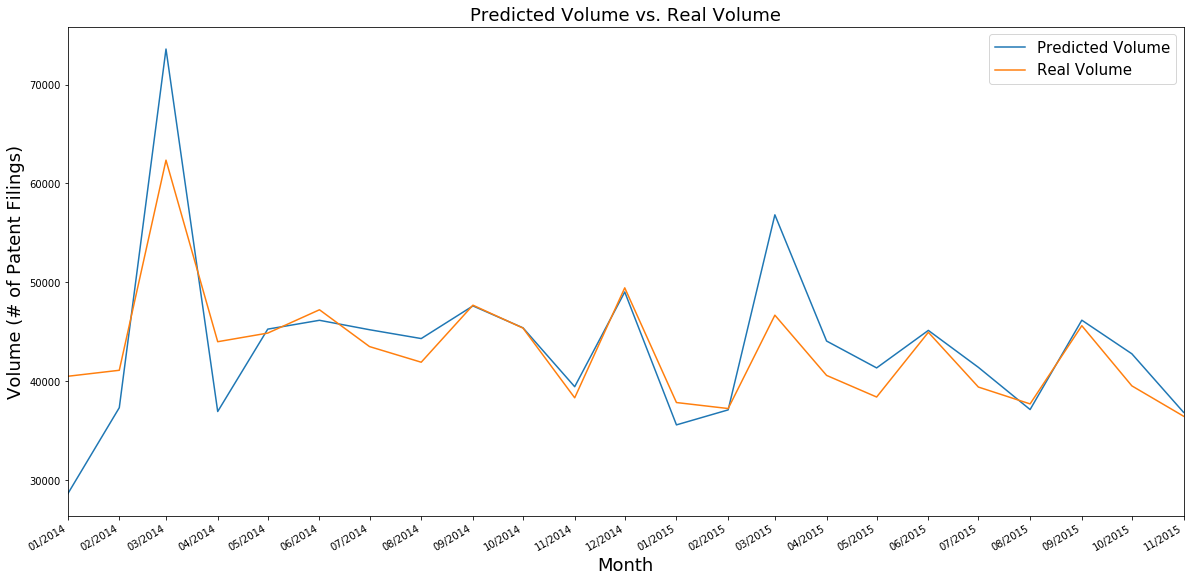

In [13]:
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in X_test['month']]
fig = plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
line1, = plt.plot(x,X_test['volPred'])
line2, = plt.plot(x,X_test['volume'])
plt.title('Predicted Volume vs. Real Volume', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Volume (# of Patent Filings)', fontsize=18)
plt.legend((line1, line2), ('Predicted Volume', 'Real Volume'), prop={'size': 15})
plt.xlim(dt.datetime.strptime('01/01/2014', '%m/%d/%Y').date(), dt.datetime.strptime('11/01/2015', '%m/%d/%Y').date())
plt.gcf().autofmt_xdate()
fig.savefig('predicted_vs_real_volumev2.jpg')

In [14]:
sortParams = sorted([(abs(fitParams[x]), trendVolShiftDictionary[variables[x]]) for x in range(len(fitParams)) if fitParams[x]!=1])[::-1]
print('\t\t   Most Important Parameters')
df = pd.DataFrame({'Trend':[], 'Standardized Coefficient':[]})
for i, val in enumerate(sortParams):
    df = df.append({'Trend': val[1], 'Standardized Coefficient':val[0]}, ignore_index=True)
print(df)

		   Most Important Parameters
    Standardized Coefficient                       Trend
0                   0.632613                  volShift12
1                   0.318228                  volShift10
2                   0.241018                  volShift11
3                   0.218270                       USPTO
4                   0.177142                   volShift4
5                   0.170409                   volShift5
6                   0.154433   Patent Application Search
7                   0.122490              Cost Of Patent
8                   0.114168                   volShift7
9                   0.109541                   volShift6
10                  0.102815                   volShift3
11                  0.098933                   volShift1
12                  0.093497                 Patentsview
13                  0.088634                   volShift9
14                  0.077779                   volShift8
15                  0.077276  Patent Application Process
